# Analysis BlueBuilder Column
This notebook uses the brainbuilder library to perform some basic analysis of the columns resulting from previous runs of bluebuilder

In [1]:
from brainbuilder.utils import bbp
from voxcell import build

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import fractions
from voxcellview.widget import VoxcellWidget
import report

/home/courcol/DEV/notebook_extensions/BrainBuilder/platform_venv/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
column_paths = (
    '../data/bbp_circuits/SomatosensoryCxS1-v5.r0_O1/0/circuit.mvd2',
    '../data/bbp_circuits/SomatosensoryCxS1-v5.r0_O1/1/circuit.mvd2',
    '../data/bbp_circuits/SomatosensoryCxS1-v5.r0_O1/2/circuit.mvd2',
    '../data/bbp_circuits/SomatosensoryCxS1-v5.r0_O1/3/circuit.mvd2',
    '../data/bbp_circuits/SomatosensoryCxS1-v5.r0_O1/4/circuit.mvd2',
    '../data/bbp_circuits/SomatosensoryCxS1-v5.r0_O1/5/circuit.mvd2',
    '../data/bbp_circuits/SomatosensoryCxS1-v5.r0_O1/6/circuit.mvd2'
)

bbp_columns = [bbp.load_mvd2(c) for c in column_paths]

bbp_merged = bbp.load_mvd2('../data/bbp_circuits/SomatosensoryCxS1-v5.r0_O1/merged_circuit/circuit.mvd2')

Take some data from your standard recipe and mesobuilder configuration to define the size of the hexagon and of the tiling

In [3]:
# data from the recipe:
recipe_filename = "../data/bbp_recipe/builderRecipeAllPathways.xml"
neurondb_filename = '../data/bbp_recipe/neurondb.dat'

lattice_vectors = {
    'a1': np.array([230.92, 0.0]),
    'a2': np.array([-115.46, 199.98]),
}

layer_heights_microns = {
    1: 164.94915873,
    2: 148.87602025,
    3: 352.92508322,
    4: 189.57183895,
    5: 525.05585701,
    6: 700.37845971
}

# data from the O1 meso_conf.yaml
mosaic_n1 = 3
mosaic_n2 = 3
mosaic_coords_mask = [(0, 0), (0, 2)]

In [4]:
hexagon_side = np.sqrt(np.sum(np.square(lattice_vectors['a1'])))

## Hexagon

Check the shape of the hexagon for each individual column

In [5]:
report.check_hexagon_diameter(bbp_columns, hexagon_side)

Column 0: X component is 53.749850 (11.638197%) microns bigger than hexagon diameter
Column 1: X component is 38.602629 (8.358442%) microns bigger than hexagon diameter
Column 1: Z component is 6.932949 (1.501158%) microns bigger than hexagon diameter
Column 2: X component is 35.377496 (7.660120%) microns bigger than hexagon diameter
Column 2: Z component is 3.937069 (0.852475%) microns bigger than hexagon diameter
Column 3: X component is 34.490627 (7.468090%) microns bigger than hexagon diameter
Column 3: Z component is 2.068075 (0.447790%) microns bigger than hexagon diameter
Column 4: X component is 42.505858 (9.203590%) microns bigger than hexagon diameter
Column 5: X component is 39.066053 (8.458785%) microns bigger than hexagon diameter
Column 6: X component is 47.049078 (10.187311%) microns bigger than hexagon diameter


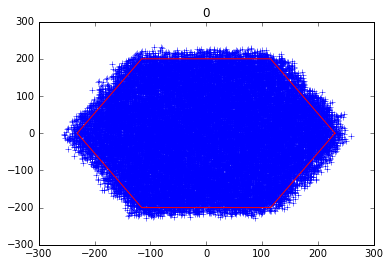

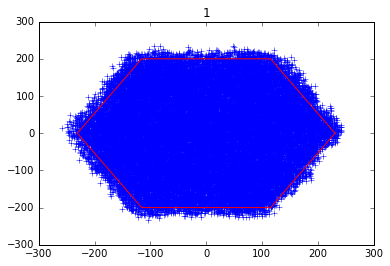

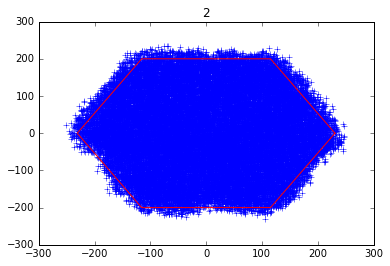

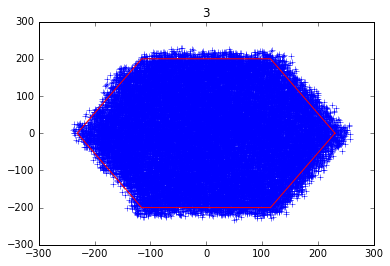

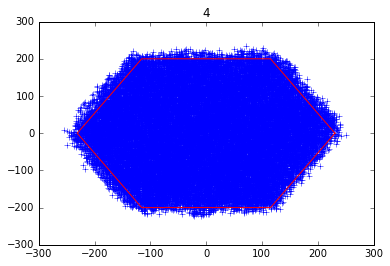

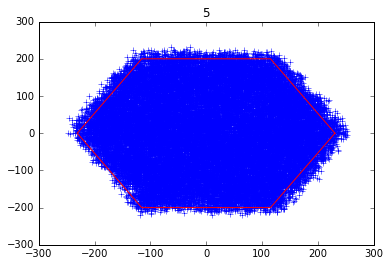

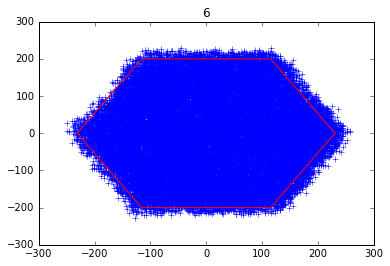

In [6]:
def plot_hexagon(title, column):
    angles = np.arange(6 + 1) * ((2 * np.pi) / 6)
    points = hexagon_side * np.array([np.cos(angles), np.sin(angles)]).transpose()

    offset = lattice_vectors['a1'] * 1.5 + lattice_vectors['a2']

    plt.figure()
    plt.title(title)
    plt.plot(column.positions[:, 0] - offset[0], column.positions[:, 2] - offset[1], 'b+')
    plt.plot(points[:, 0], points[:, 1], 'r-')

for i, c in enumerate(bbp_columns):
    plot_hexagon(str(i), c)

Note in the plots above how the columns are trying to avoid overlapping with the previously built columns. This causes the volume that column 6 can span to be less than that of column 0. However the number of cells is the same for all of them, which means later columns are more dense that the first ones.

The graph below shows the density of a cylinder at the center of each column (to avoid edge effects). See how all of the columns have a density higher than column 0.

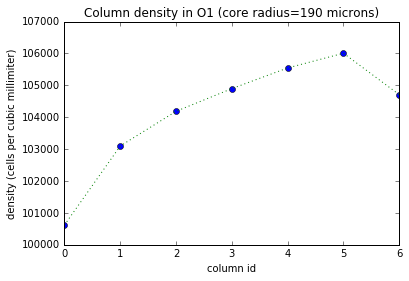

In [7]:
height = np.sum(layer_heights_microns.values())
densities = report.calculate_columns_densities(bbp_columns, height, 190)
plt.plot(densities * (10 ** 9), 'o')
plt.plot(densities * (10 ** 9), ':')
plt.title('Column density in O1 (core radius=%d microns)' % 190)
plt.xlabel('column id')
plt.ylabel('density (cells per cubic millimiter)')

The graph below presents the same type of information but for 12 different O1 circuits that were built with the same binaries, recipe and mesobuilder configuration as the SomatosensoryCxS1-v5.r0. Note how column 0 tends to have the lowest density (because it was built in isolation) and column 6 to the highest (because it was constrained in 3 of its sides).

<img src="assets/microcircuit_column_density.png" align="left">

## Tiling

Check if the tiling produces any density anomalies or collisions around the edges of the columns

In [8]:
bbp_density = build.density_from_positions(bbp_merged.positions, (10, 10, 10))
print bbp_density.raw.shape
VoxcellWidget().show_volume('merged_density', bbp_density.raw > 1, display_parameters={"particle_size": 1})

(121, 209, 126)


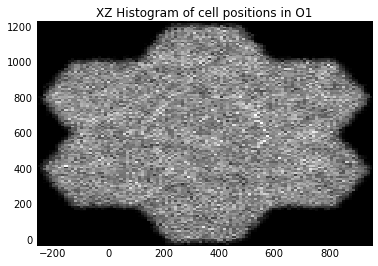

In [9]:
_ = plt.hist2d(bbp_merged.positions[:, 0], bbp_merged.positions[:, 2], bins=(110, 120), cmap='binary_r')
plt.title('XZ Histogram of cell positions in O1')

The graph below presents the same type of information but for 12 different O1 circuits that were built with the same binaries, recipe and mesobuilder configuration as the SomatosensoryCxS1-v5.r0.

<img src="assets/microcircuit_O1_hist2d.png" align="left">

## Cell height

Check the distribution of cells along the Y component

The next test looks at each one of the 7 columns and layers sepparately. Notice the abrupt change in density that seems to happen to most layers right in the middle. The reason for this is unclear but possibly a problem with either placement hints or the variety of heights for the available morphologies.

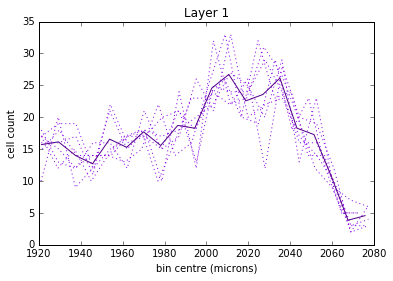

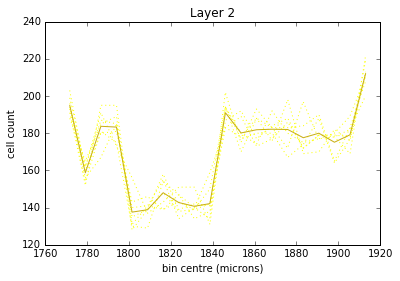

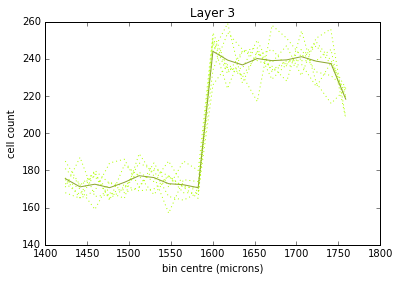

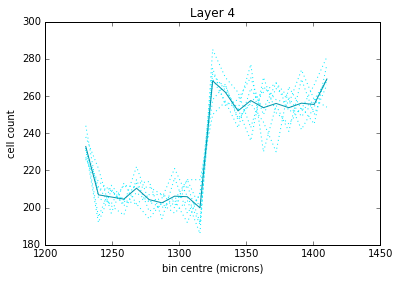

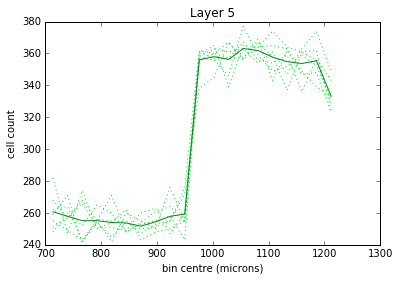

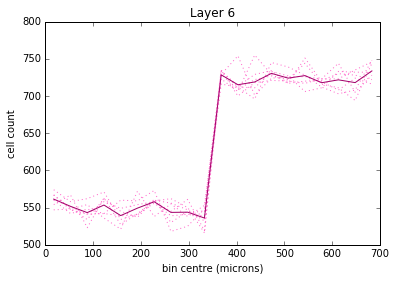

In [10]:
report.report_height_histogram(bbp_columns)

## Cell counts

In [11]:
recipe = bbp.get_distribution_from_recipe(recipe_filename)
recipe.layer -= 1  # in the recipe they are indexed by 1 but in the mvd2 they are by 0

Compare the percentages of cells grouped by layer with the values specified in the recipe.

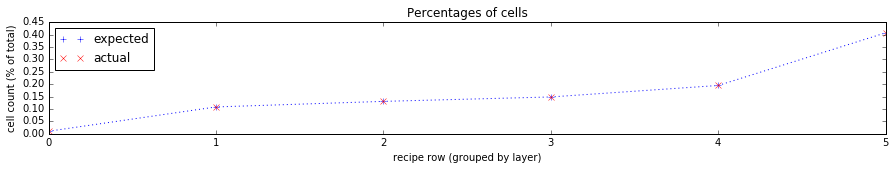

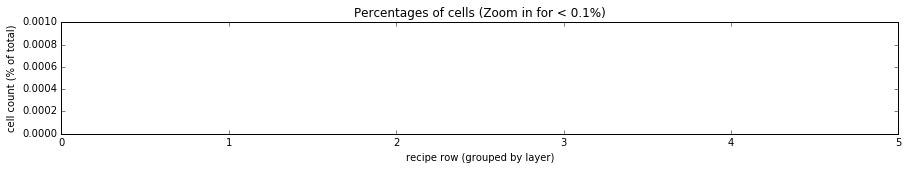

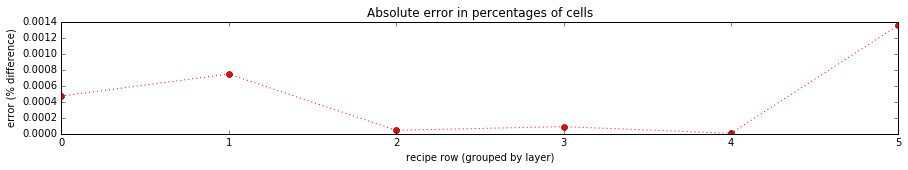

In [12]:
report.report_cell_percentages(recipe, [bbp_columns[0]], ['layer'])

Compare the percentages of cells grouped by layer-mtype-etype with the values specified in the recipe.

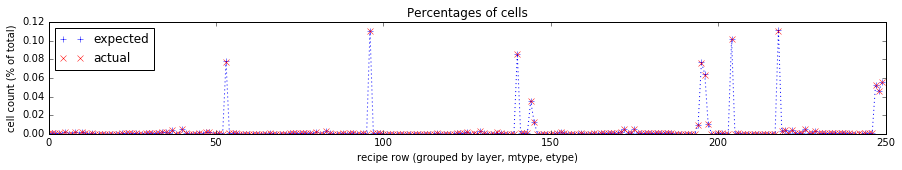

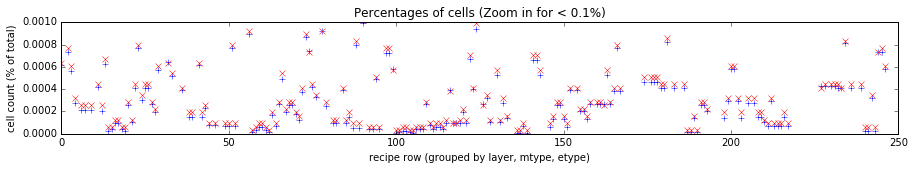

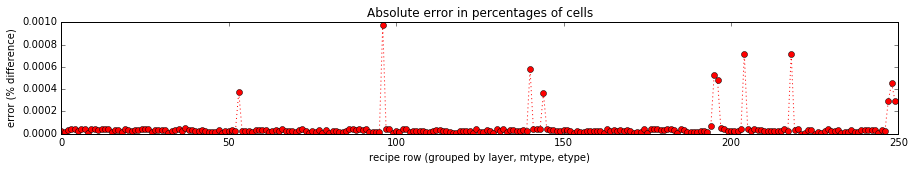

In [13]:
report.report_cell_percentages(recipe, [bbp_columns[0]], ['layer', 'mtype', 'etype'])

In [14]:
neurondb = bbp.load_neurondb_v4(neurondb_filename)
neurondb.layer -= 1  # in the neurondb they are indexed by 1 but in the mvd2 they are by 0

Check morphology usage

In [15]:
total_unique_morphs = neurondb.shape[0]
for i, c in enumerate(bbp_columns):
    unique_morphs = len(c.properties.morphology.unique())
    print 'column %d number of cells: %d unique morphologies: %d (%f%% of available)' % (i, c.positions.shape[0], unique_morphs, unique_morphs * 100.0/ total_unique_morphs)

unique_morphs = len(bbp_merged.properties.morphology.unique())
print 'mosaic number of cells: %d unique morphologies: %d (%f%% of available)' % (bbp_merged.positions.shape[0], unique_morphs, unique_morphs * 100.0/ total_unique_morphs)

column 0 number of cells: 31346 unique morphologies: 9877 (8.147256% of available)
column 1 number of cells: 31346 unique morphologies: 9845 (8.120860% of available)
column 2 number of cells: 31346 unique morphologies: 9849 (8.124160% of available)
column 3 number of cells: 31346 unique morphologies: 9875 (8.145606% of available)
column 4 number of cells: 31346 unique morphologies: 9799 (8.082916% of available)
column 5 number of cells: 31346 unique morphologies: 9830 (8.108487% of available)
column 6 number of cells: 31346 unique morphologies: 9868 (8.139832% of available)
mosaic number of cells: 219422 unique morphologies: 19726 (16.271416% of available)


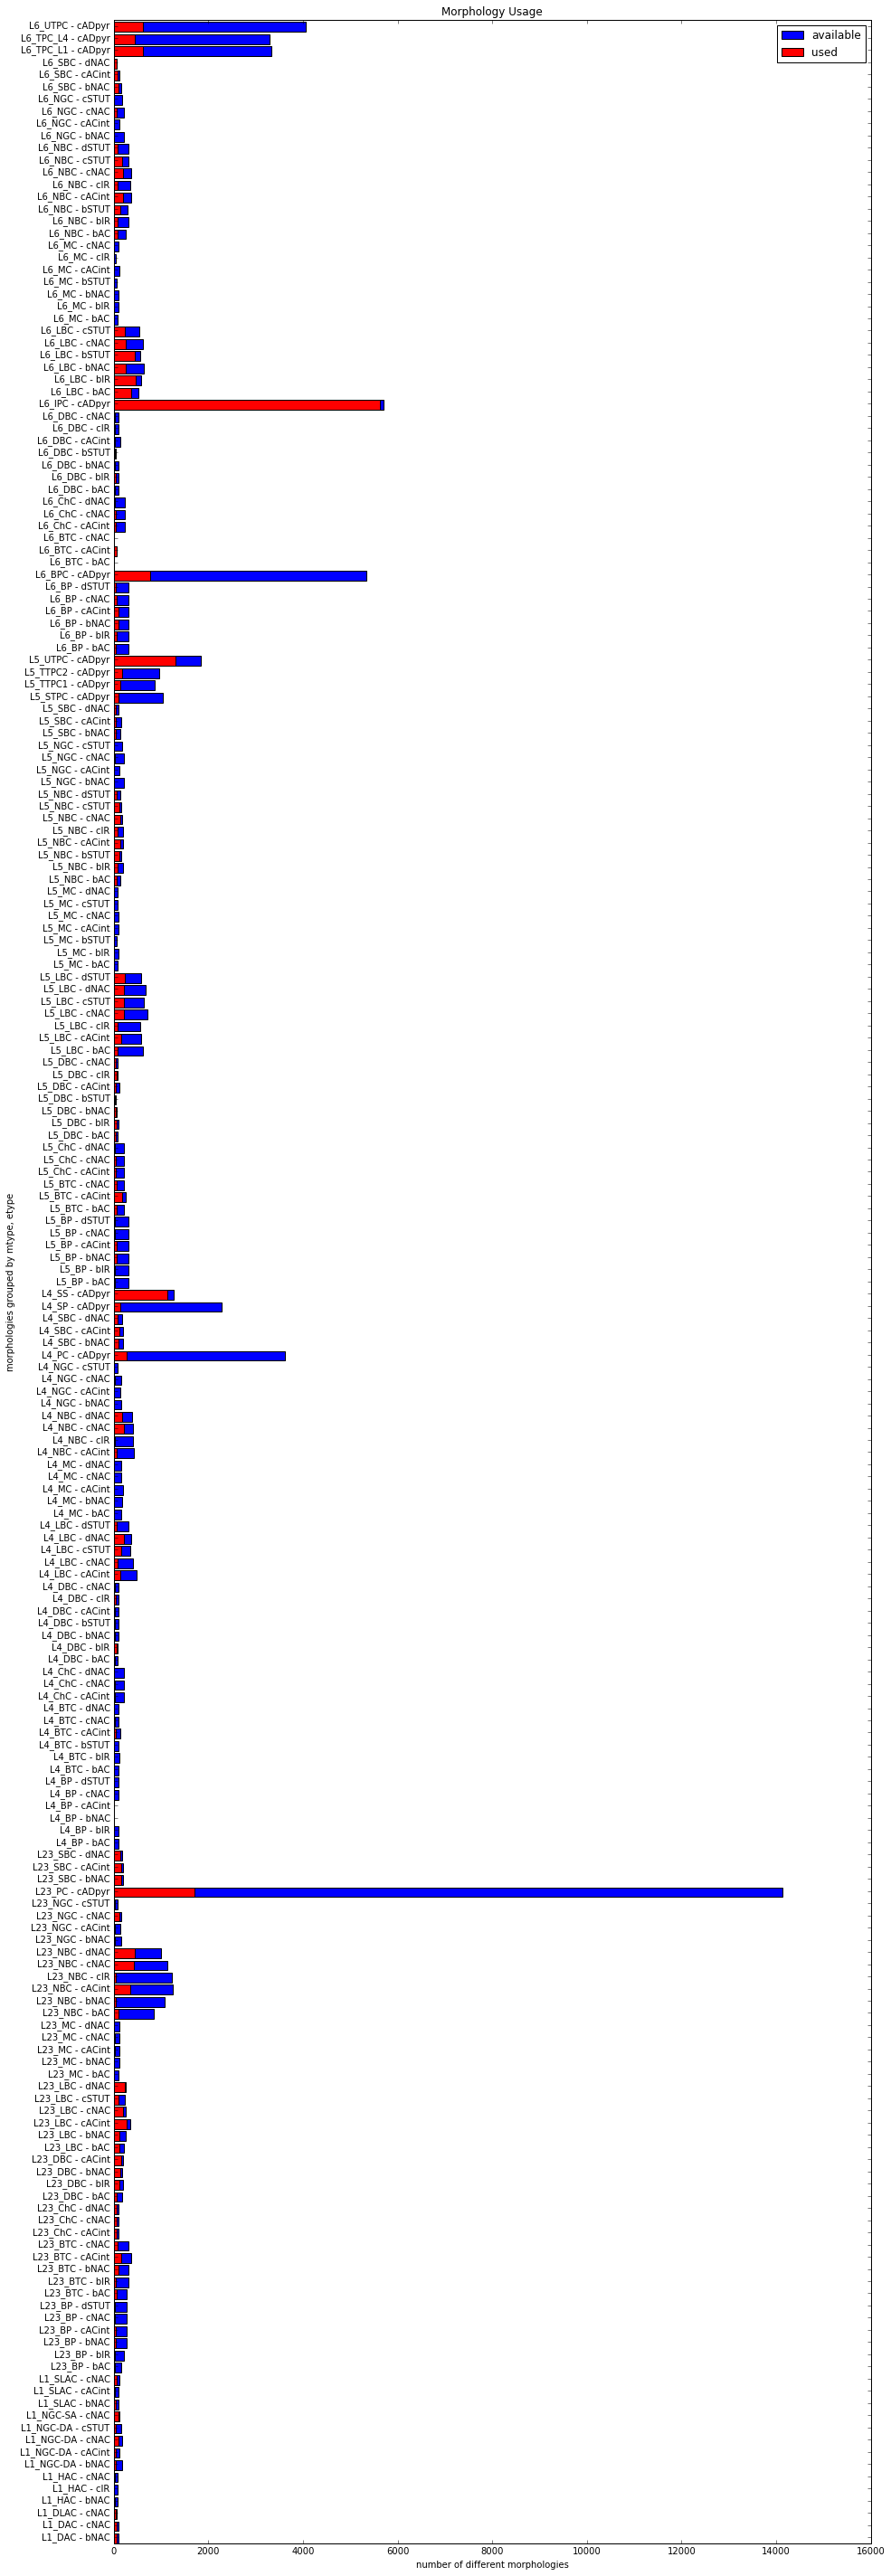

In [16]:
report.report_morphology_used(neurondb, bbp_merged)

## Placement Hints
Look for layer-mtype-etype groups of morphologies whose placement hints define bins with zero probability. In other words, combinations of layer-mtype-etype for which there are parts of the layer where no valid morphology exists.

0 L1_HAC cIR contains 2 bins with score zero
0 L1_NGC-DA cACint contains 1 bins with score zero
0 L1_DAC cNAC contains 3 bins with score zero
0 L1_DAC bNAC contains 3 bins with score zero
0 L1_NGC-DA bNAC contains 1 bins with score zero
0 L1_HAC bNAC contains 1 bins with score zero
0 L1_DLAC cNAC contains 4 bins with score zero
0 L1_NGC-DA cSTUT contains 1 bins with score zero
0 L1_NGC-DA cNAC contains 1 bins with score zero
0 L1_HAC cNAC contains 2 bins with score zero
0 L1_SLAC cACint contains 2 bins with score zero
0 L1_SLAC bNAC contains 2 bins with score zero
0 L1_SLAC cNAC contains 2 bins with score zero
1 L23_MC bAC contains 11 bins with score zero
1 L23_MC dNAC contains 11 bins with score zero
1 L23_MC cACint contains 11 bins with score zero
1 L23_MC cNAC contains 11 bins with score zero
1 L23_MC bNAC contains 11 bins with score zero
1 L23_BTC bAC contains 1 bins with score zero


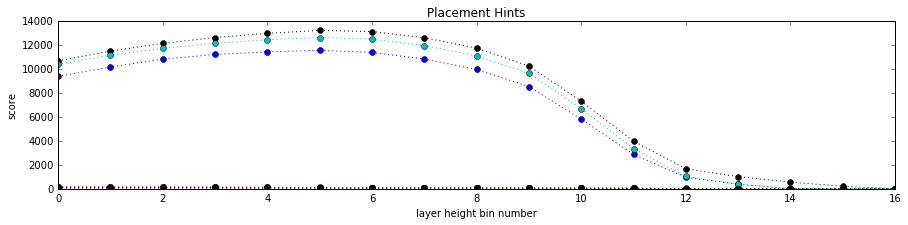

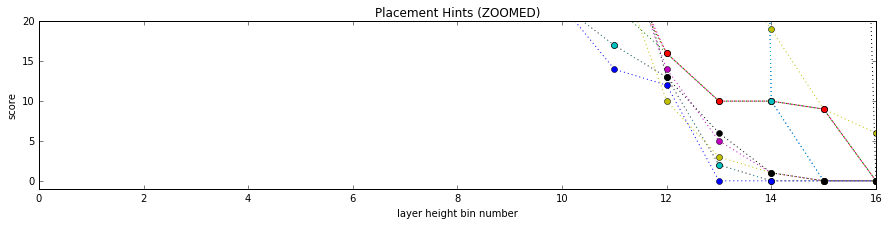

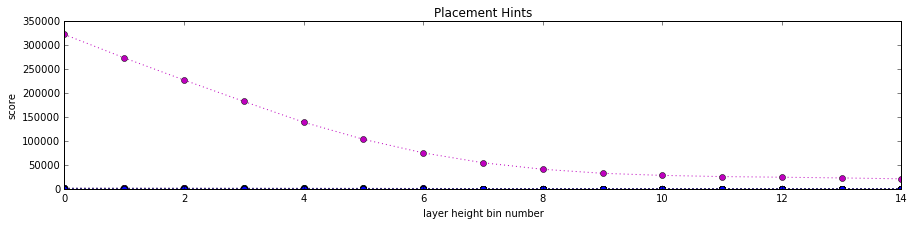

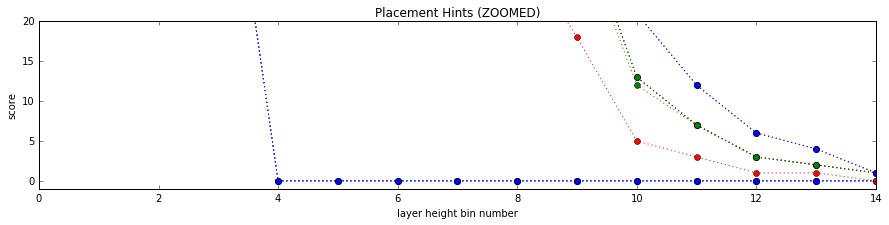

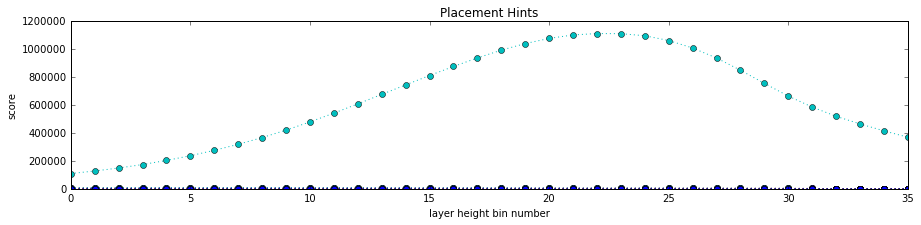

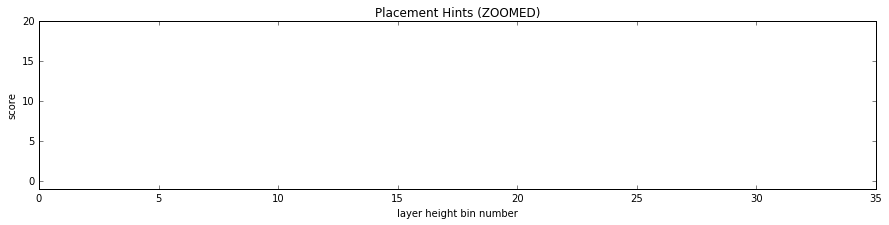

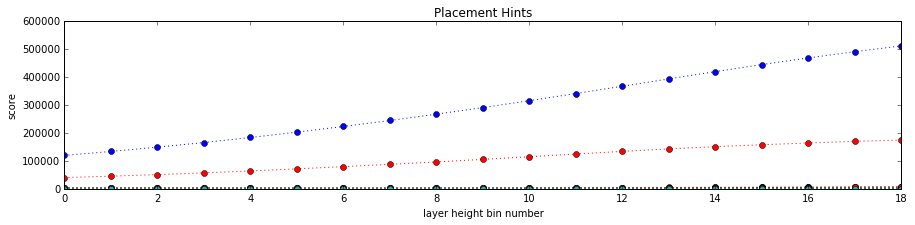

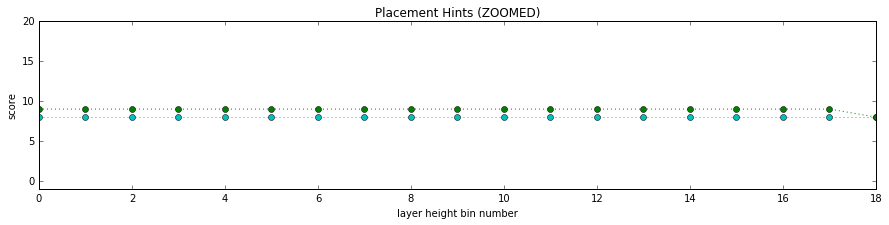

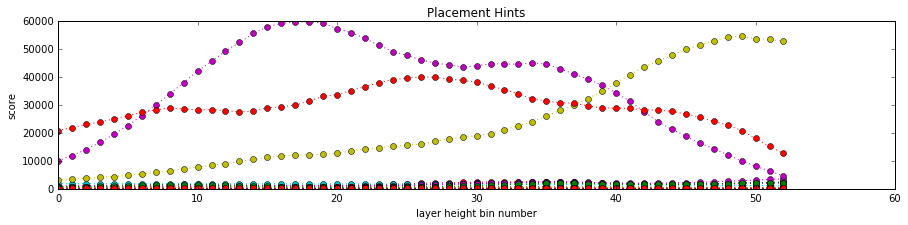

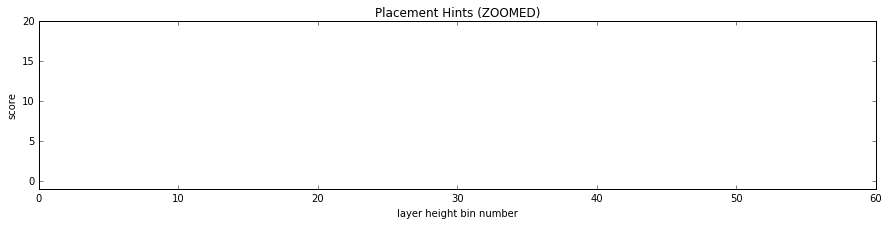

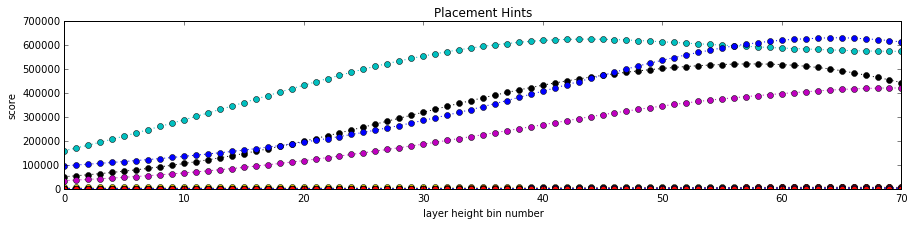

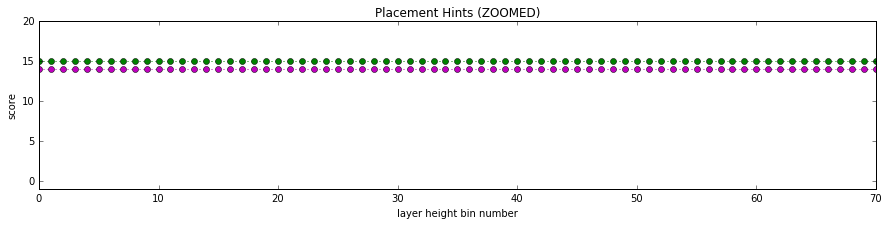

In [17]:
hints = report.collect_placement_hints(neurondb)
report.report_placement_hints(hints)